# Panan005 Bottom salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42563/status,
Dashboard: /proxy/42563/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45749,Workers: 28
Dashboard: /proxy/42563/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39939,Total threads: 1
Dashboard: /proxy/33365/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:43977,


2025-08-18 09:20:51,160 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-9dcf2473f4b9eb2da70641069b9dee99', 1, 4) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('getitem-9dcf2473f4b9eb2da70641069b9dee99', 1, 4) getitem(...)>
new run_spec: Alias(('getitem-9dcf2473f4b9eb2da70641069b9dee99', 1, 4)->('concatenate-where-getitem-9dcf2473f4b9eb2da70641069b9dee99', 1, 4))
old dependencies: {('concatenate-96d48203fd7b500b38969bd3a3aba9c3', 0, 0, 1, 4)}
new dependencies: {('concatenate-where-getitem-9dcf2473f4b9eb2da70641069b9dee99', 1, 4)}

2025-08-18 09:25:27,967 - distributed.scheduler - 

In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds['so'].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
#Time invariant variables
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [10]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

In [11]:
# Correcting area
area_corr = area*(saltC.isel(time=0,z_l=0)*0 +1)

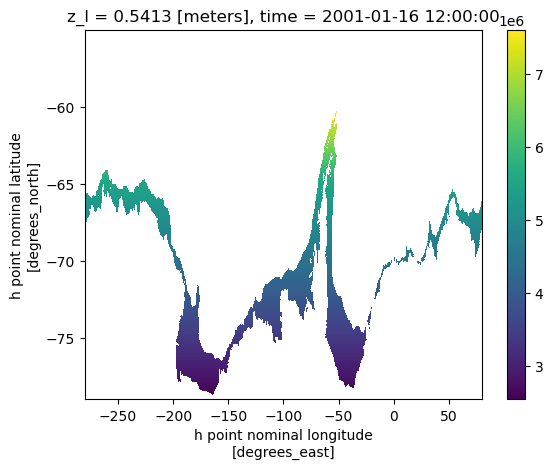

In [12]:
area_corr.plot()

### Creating the regions

In [13]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

Adelie = slice(AdelieW,AdelieE)
Ross = slice(RossW, RossE)
Am = slice(AmW, AmE)
Be = slice(BeW,BeE)
Weddell = slice(WeddellW, WeddellE)
Prydz = slice(PrydzW, PrydzE)

## Bottom mask

In [14]:
bottom_mask_saltC = saltC.where(~np.isfinite(saltC.shift({'z_l': -1})))
bottom_mask_saltC = ~np.isnan(bottom_mask_saltC)

In [15]:
bottom_mask_saltM = saltM.where(~np.isfinite(saltM.shift({'z_l': -1})))
bottom_mask_saltM = ~np.isnan(bottom_mask_saltM)

In [16]:
botsalt_cont = saltC.where(bottom_mask_saltC).sum(dim='z_l')
botsalt_pert = saltM.where(bottom_mask_saltM).sum(dim='z_l')

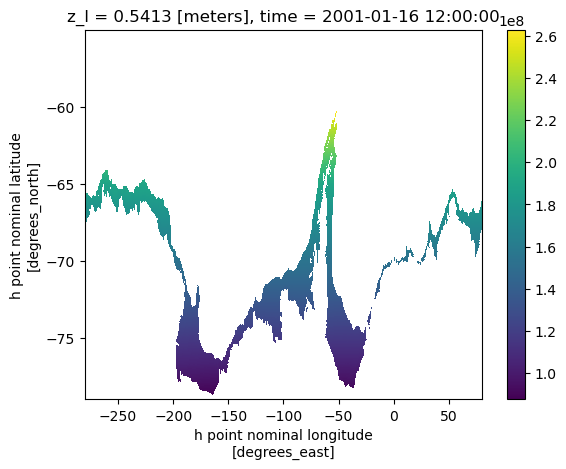

In [17]:
# Checking mask
(area_corr * botsalt_cont.isel(time=0)).plot()

#### Time series

In [18]:
# Restricting to regions
botsalt_cont_1 = botsalt_cont.sel(xh=Adelie)
botsalt_pert_1 = botsalt_pert.sel(xh=Adelie)

botsalt_cont_2 = botsalt_cont.sel(xh=Ross)
botsalt_pert_2 = botsalt_pert.sel(xh=Ross)

botsalt_cont_3 = botsalt_cont.sel(xh=Am)
botsalt_pert_3 = botsalt_pert.sel(xh=Am)

botsalt_cont_4 = botsalt_cont.sel(xh=Be)
botsalt_pert_4 = botsalt_pert.sel(xh=Be)

botsalt_cont_5 = botsalt_cont.sel(xh=Weddell)
botsalt_pert_5 = botsalt_pert.sel(xh=Weddell)

botsalt_cont_6 = botsalt_cont.sel(xh=Prydz)
botsalt_pert_6 = botsalt_pert.sel(xh=Prydz)

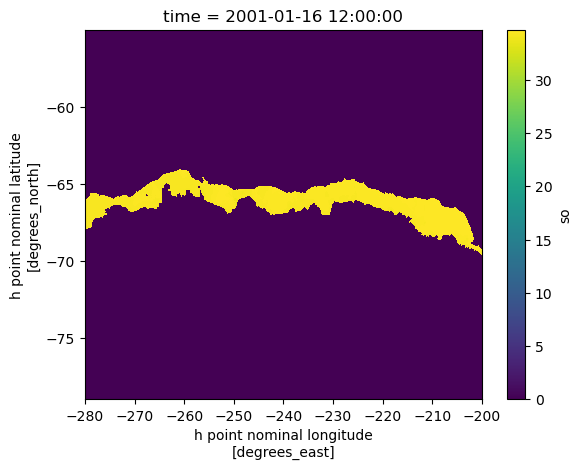

In [20]:
botsalt_cont_1.isel(time=0).plot()

In [19]:
# Spatial averages
botsalt_cont_1_time = (area_corr * botsalt_cont_1).sum(['xh', 'yh']) / area_corr.sel(xh=Adelie).sum(['xh', 'yh'])
botsalt_pert_1_time = (area_corr * botsalt_pert_1).sum(['xh', 'yh']) / area_corr.sel(xh=Adelie).sum(['xh', 'yh'])

botsalt_cont_2_time = (area_corr * botsalt_cont_2).sum(['xh', 'yh']) / area_corr.sel(xh=Ross).sum(['xh', 'yh'])
botsalt_pert_2_time = (area_corr * botsalt_pert_2).sum(['xh', 'yh']) / area_corr.sel(xh=Ross).sum(['xh', 'yh'])

botsalt_cont_3_time = (area_corr * botsalt_cont_3).sum(['xh', 'yh']) / area_corr.sel(xh=Am).sum(['xh', 'yh'])
botsalt_pert_3_time = (area_corr * botsalt_pert_3).sum(['xh', 'yh']) / area_corr.sel(xh=Am).sum(['xh', 'yh'])

botsalt_cont_4_time = (area_corr * botsalt_cont_4).sum(['xh', 'yh']) / area_corr.sel(xh=Be).sum(['xh', 'yh'])
botsalt_pert_4_time = (area_corr * botsalt_pert_4).sum(['xh', 'yh']) / area_corr.sel(xh=Be).sum(['xh', 'yh'])

botsalt_cont_5_time = (area_corr * botsalt_cont_5).sum(['xh', 'yh']) / area_corr.sel(xh=Weddell).sum(['xh', 'yh'])
botsalt_pert_5_time = (area_corr * botsalt_pert_5).sum(['xh', 'yh']) / area_corr.sel(xh=Weddell).sum(['xh', 'yh'])

botsalt_cont_6_time = (area_corr * botsalt_cont_6).sum(['xh', 'yh']) / area_corr.sel(xh=Prydz).sum(['xh', 'yh'])
botsalt_pert_6_time = (area_corr * botsalt_pert_6).sum(['xh', 'yh']) / area_corr.sel(xh=Prydz).sum(['xh', 'yh'])

In [21]:
# Check shape
botsalt_cont_1_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [22]:
botsalt_cont_1_time = botsalt_cont_1_time.load()
botsalt_pert_1_time = botsalt_pert_1_time.load()

In [23]:
botsalt_cont_2_time = botsalt_cont_2_time.load()
botsalt_pert_2_time = botsalt_pert_2_time.load()

In [24]:
botsalt_cont_3_time = botsalt_cont_3_time.load()
botsalt_pert_3_time = botsalt_pert_3_time.load()

In [25]:
botsalt_cont_4_time = botsalt_cont_4_time.load()
botsalt_pert_4_time = botsalt_pert_4_time.load()

In [26]:
botsalt_cont_5_time = botsalt_cont_5_time.load()
botsalt_pert_5_time = botsalt_pert_5_time.load()

2025-08-18 09:29:18,284 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:45721 -> tcp://127.0.0.1:35249
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [27]:
botsalt_cont_6_time = botsalt_cont_6_time.load()
botsalt_pert_6_time = botsalt_pert_6_time.load()

In [28]:
botsalt_anom_1_time = botsalt_pert_1_time - botsalt_cont_1_time
botsalt_anom_1_time = botsalt_anom_1_time.load()
botsalt_anom_1_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Adelie_pan005.nc')

In [29]:
botsalt_anom_2_time = botsalt_pert_2_time - botsalt_cont_2_time
botsalt_anom_2_time = botsalt_anom_2_time.load()
botsalt_anom_2_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Ross_pan005.nc')

In [30]:
botsalt_anom_3_time = botsalt_pert_3_time - botsalt_cont_3_time
botsalt_anom_3_time = botsalt_anom_3_time.load()
botsalt_anom_3_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Am_pan005.nc')

In [31]:
botsalt_anom_4_time = botsalt_pert_4_time - botsalt_cont_4_time
botsalt_anom_4_time = botsalt_anom_4_time.load()
botsalt_anom_4_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Be_pan005.nc')

In [32]:
botsalt_anom_5_time = botsalt_pert_5_time - botsalt_cont_5_time
botsalt_anom_5_time = botsalt_anom_5_time.load()
botsalt_anom_5_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Weddell_pan005.nc')

In [33]:
botsalt_anom_6_time = botsalt_pert_6_time - botsalt_cont_6_time
botsalt_anom_6_time = botsalt_anom_6_time.load()
botsalt_anom_6_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Prydz_pan005.nc')

#### Plotting all

Text(0.5, 1.0, 'Pan005 Time Series of Bottom Salinity on Shelf, Sector regions')

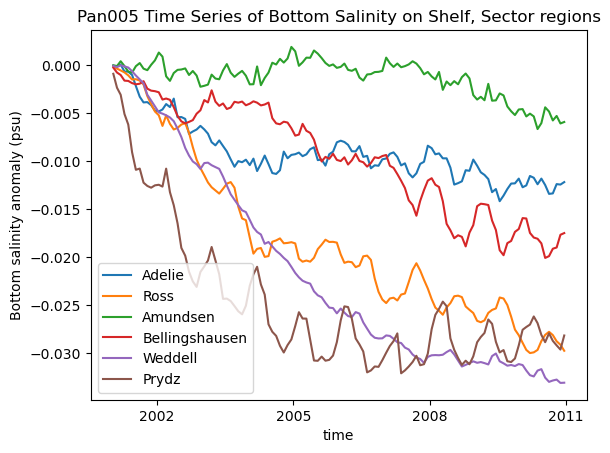

In [36]:
botsalt_anom_1_time.plot(label="Adelie")
botsalt_anom_2_time.plot(label="Ross")
botsalt_anom_3_time.plot(label="Amundsen")
botsalt_anom_4_time.plot(label="Bellingshausen")
botsalt_anom_5_time.plot(label="Weddell")
botsalt_anom_6_time.plot(label="Prydz")
plt.ylabel("Bottom salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("Pan005 Time Series of Bottom Salinity on Shelf, Sector regions")

## Comparing between models

In [37]:
# Importing data
pan01_botsalt_1 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Adelie_pan01.nc', chunks='auto') 
pan005_botsalt_1 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Adelie_pan005.nc', chunks='auto')

pan01_botsalt_2 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Ross_pan01.nc', chunks='auto') 
pan005_botsalt_2 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Ross_pan005.nc', chunks='auto')

pan01_botsalt_3 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Am_pan01.nc', chunks='auto') 
pan005_botsalt_3 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Am_pan005.nc', chunks='auto')

pan01_botsalt_4 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Be_pan01.nc', chunks='auto') 
pan005_botsalt_4 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Be_pan005.nc', chunks='auto')

pan01_botsalt_5 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Weddell_pan01.nc', chunks='auto') 
pan005_botsalt_5 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Weddell_pan005.nc', chunks='auto')

pan01_botsalt_6 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Prydz_pan01.nc', chunks='auto') 
pan005_botsalt_6 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_Prydz_pan005.nc', chunks='auto')

In [38]:
pan01_botsalt_1_new = pan01_botsalt_1.to_series()
pan005_botsalt_1_new = pan005_botsalt_1.to_series()

pan01_botsalt_2_new = pan01_botsalt_2.to_series()
pan005_botsalt_2_new = pan005_botsalt_2.to_series()

pan01_botsalt_3_new = pan01_botsalt_3.to_series()
pan005_botsalt_3_new = pan005_botsalt_3.to_series()

pan01_botsalt_4_new = pan01_botsalt_4.to_series()
pan005_botsalt_4_new = pan005_botsalt_4.to_series()

pan01_botsalt_5_new = pan01_botsalt_5.to_series()
pan005_botsalt_5_new = pan005_botsalt_5.to_series()

pan01_botsalt_6_new = pan01_botsalt_6.to_series()
pan005_botsalt_6_new = pan005_botsalt_6.to_series()

In [39]:
import pandas as pd

In [40]:
# Reset index to normalized months
pan01_botsalt_1_new.index = range(0, len(pan01_botsalt_1_new))
pan005_botsalt_1_new.index = range(0, len(pan005_botsalt_1_new))

pan01_botsalt_2_new.index = range(0, len(pan01_botsalt_2_new))
pan005_botsalt_2_new.index = range(0, len(pan005_botsalt_2_new))

pan01_botsalt_3_new.index = range(0, len(pan01_botsalt_3_new))
pan005_botsalt_3_new.index = range(0, len(pan005_botsalt_3_new))

pan01_botsalt_4_new.index = range(0, len(pan01_botsalt_4_new))
pan005_botsalt_4_new.index = range(0, len(pan005_botsalt_4_new))

pan01_botsalt_5_new.index = range(0, len(pan01_botsalt_5_new))
pan005_botsalt_5_new.index = range(0, len(pan005_botsalt_5_new))

pan01_botsalt_6_new.index = range(0, len(pan01_botsalt_6_new))
pan005_botsalt_6_new.index = range(0, len(pan005_botsalt_6_new))

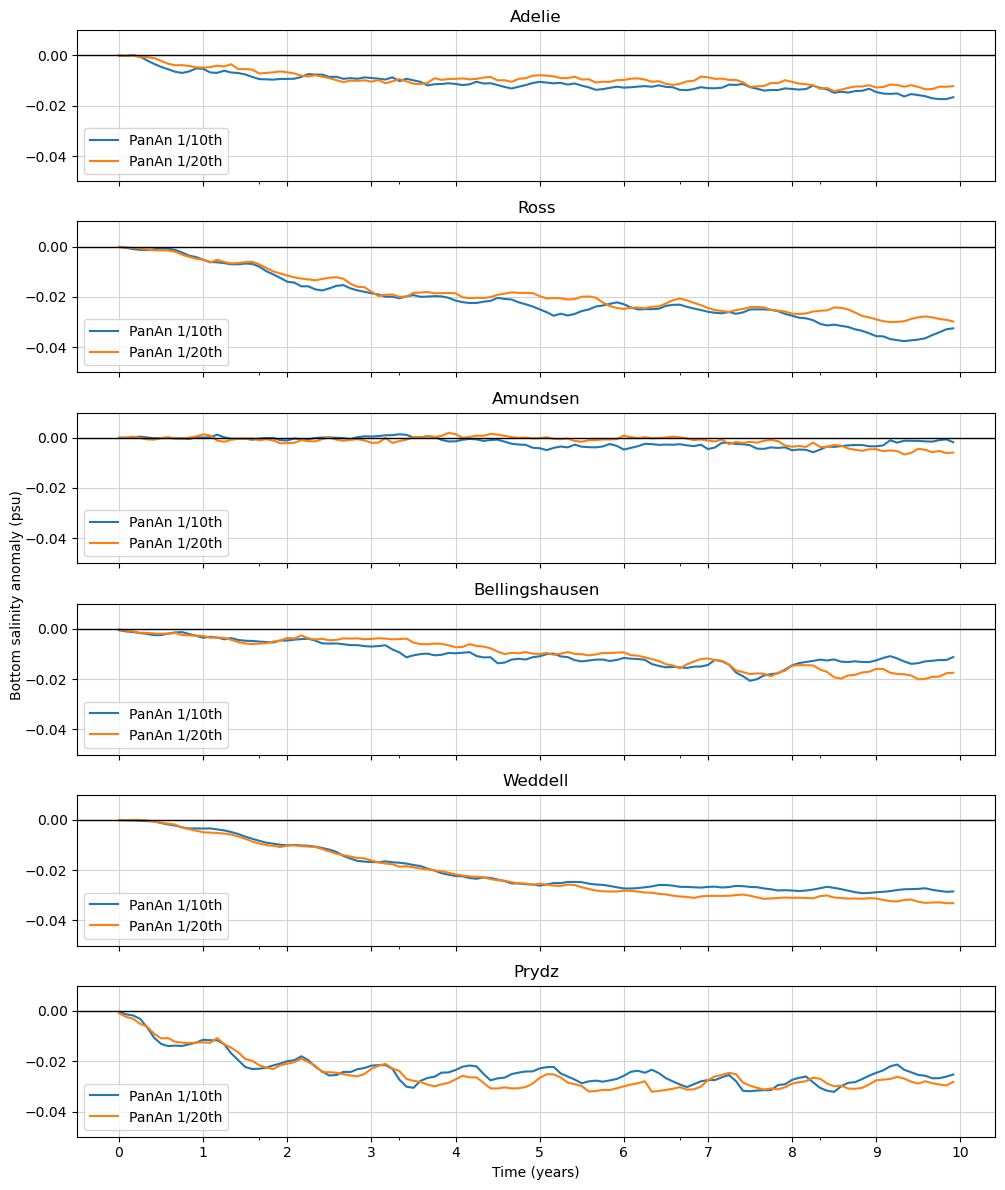

In [41]:
fig, axes = plt.subplots(
    nrows=6, ncols=1,
    sharex=True, figsize=(10, 12)
)

# First subplot: 
pan01_botsalt_1_new.plot(ax=axes[0], label="PanAn 1/10th")
pan005_botsalt_1_new.plot(ax=axes[0], label="PanAn 1/20th")
axes[0].legend(loc="lower left")
axes[0].set_title("Adelie")

# Second subplot: 
pan01_botsalt_2_new.plot(ax=axes[1], label="PanAn 1/10th")
pan005_botsalt_2_new.plot(ax=axes[1], label="PanAn 1/20th")
axes[1].legend(loc="lower left")
axes[1].set_title("Ross")

# Third subplot: 
pan01_botsalt_3_new.plot(ax=axes[2], label="PanAn 1/10th")
pan005_botsalt_3_new.plot(ax=axes[2], label="PanAn 1/20th")
axes[2].legend(loc="lower left")
axes[2].set_title("Amundsen")

# Fourth subplot: 
pan01_botsalt_4_new.plot(ax=axes[3], label="PanAn 1/10th")
pan005_botsalt_4_new.plot(ax=axes[3], label="PanAn 1/20th")
axes[3].legend(loc="lower left")
axes[3].set_title("Bellingshausen")

# Fifth subplot: 
pan01_botsalt_5_new.plot(ax=axes[4], label="PanAn 1/10th")
pan005_botsalt_5_new.plot(ax=axes[4], label="PanAn 1/20th")
axes[4].legend(loc="lower left")
axes[4].set_title("Weddell")

# Sixth subplot: 
pan01_botsalt_6_new.plot(ax=axes[5], label="PanAn 1/10th")
pan005_botsalt_6_new.plot(ax=axes[5], label="PanAn 1/20th")
axes[5].legend(loc="lower left")
axes[5].set_title("Prydz")

# Apply consistent y-limits and horizontal line for all subplots
for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.05, 0.01)
    ax.grid(True, color='lightgrey')

# Common X-axis label
axes[-1].set_xlabel("Time (years)")

# Common Y-axis label
fig.text(0, 0.5, "Bottom salinity anomaly (psu)", va='center', rotation='vertical')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

# Adjust layout
plt.tight_layout()
plt.show()